## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import torchvision
import torchvision.transforms.functional as TF
import random
import glob
from torchmetrics import JaccardIndex
from torchmetrics.classification import Dice
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import tqdm


In [2]:
import sys
sys.path.append('../src/')
import preprocess
#import json2mask
#import json2line
import constant
from preprocess_line import tensorize_image,tensorize_mask,one_hot_encoder,torchlike_data,image_mask_check
from model import Unet

In [3]:
from segnet import SegNet

## PARAMETERS

In [4]:
VALID_SIZE = 0.2
TEST_SIZE  = 0.1
BATCH_SIZE = 8
EPOCHS = 20
CUDA = False
INPUT_SHAPE = (224, 224)
N_CLASSES = 3

## DIRECTORIES

In [5]:
SRC_DIR=os.getcwd()
ROOT_DIR=os.path.join(SRC_DIR,'..')
IMAGE_DIR=os.path.join(ROOT_DIR,'images')
MASK_DIR=os.path.join(ROOT_DIR,"masks")

In [6]:
ROOT_DIR='C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\'

In [7]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [8]:
image_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out')
mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks')
line_mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks')
mask_on_image_path=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images')

In [9]:
for i in range(len(image_paths)):
    image_paths[i]=ROOT_DIR+"img_out\\"+image_paths[i]

In [10]:
for i in range(len(line_mask_paths)):
    line_mask_paths[i]=ROOT_DIR+"line_masks\\"+line_mask_paths[i]

In [11]:
for i in range(len(mask_on_image_path)):
    mask_on_image_path[i]=ROOT_DIR+"masked_images\\"+mask_on_image_path[i]

In [12]:
image_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Sta

In [13]:
mask_paths

['cfc_000234_75576fe22f704a23816456740bde3556.png',
 'cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'cfc_000249_38679c112bca4107ad224a6e7fc10c2e.png',
 'cfc_000250_8e8d9b03802545a0bcac9b7d2b9578f1.png',
 'cfc_000251_d99c886d896745b7817ed667618a954e.png',
 'cfc_000252_bc4465e2f56b43d092575c4c6833b648.png',
 'cfc_000253_a7471156614d473db7fe9e5bee2ee247.png',
 'cfc_000254_388a51e56525449796c6c07728494a51.png',
 'cfc_000255_f3b724c3232d41588e2eaa5074740d2e.png',
 'cfc_000256_0c84da99243c439fa8e4117c1a10e530.png',
 'cfc_000257_71569acad2364cd5b5ca50878673b381.png',
 'cfc_000258_81fa1134d54949209bf05a8624328ce2.png',
 'cfc_000259_06d409725bef4251af86afad57a12ee4.png',
 'cfc_000260

In [14]:
line_mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\

In [15]:
mask_on_image_path

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',


In [16]:
len(line_mask_paths)

4660

## Json2Mask

In [17]:
for i in range(len(image_paths)):
    mask_paths[i]=ROOT_DIR+"masks\\"+mask_paths[i]

In [18]:
mask=plt.imread(mask_paths[0])

In [19]:
mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\mask

In [20]:
mask=plt.imread(mask_paths[0],0)
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

In [21]:
def visualize_example_fs_mask_pair(image_paths,mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(mask_paths[random_idx],0)
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    

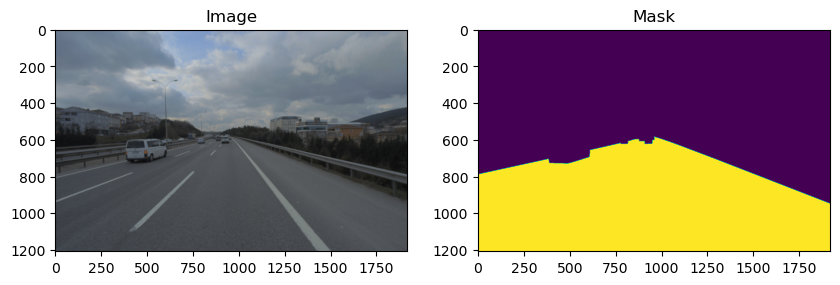

In [22]:
visualize_example_fs_mask_pair(image_paths,mask_paths)

In [23]:
def visualize_example_line_mask_pair(image_paths,line_mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(line_mask_paths[random_idx])
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    

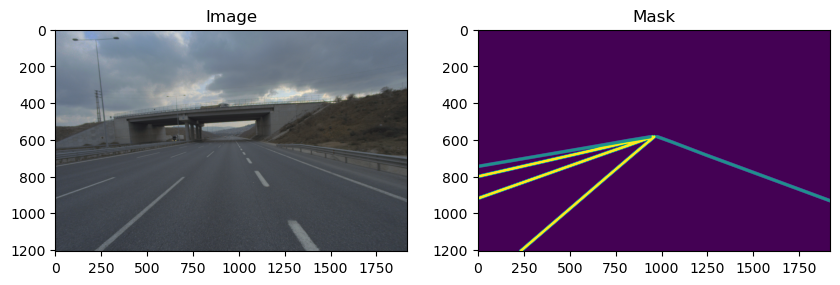

In [24]:
visualize_example_line_mask_pair(image_paths,line_mask_paths)

In [25]:
mask=plt.imread(line_mask_paths[4])

In [26]:
np.unique(mask)

array([0.        , 0.00392157, 0.00784314], dtype=float32)

In [27]:
def visualize_example_mask_on_image_pair(image_paths,mask_paths):
    random_idx=random.randint(0,10)
    image=plt.imread(image_paths[random_idx])
    mask_on_image=plt.imread(mask_paths[random_idx])
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask_on_image)
    axs[1].set_title('Mask On Image')
    

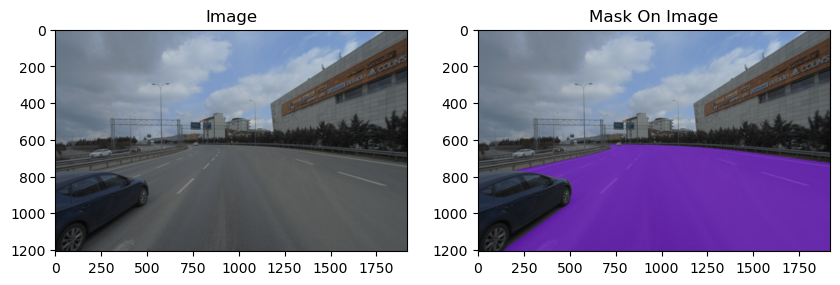

In [28]:
visualize_example_mask_on_image_pair(image_paths,mask_on_image_path)

In [29]:
image=plt.imread(image_paths[4])
mask=plt.imread(line_mask_paths[4])

In [30]:
print(f"Number of images:{len(image_paths)}")

Number of images:4660


In [31]:
print(f"Shape of the mask: {mask.shape}")
print(f"Shape of the images: {image.shape}")

Shape of the mask: (1208, 1920)
Shape of the images: (1208, 1920, 3)


In [32]:
for i,unique_val in enumerate(np.unique(mask)):
    print(i,unique_val)

0 0.0
1 0.003921569
2 0.007843138


In [33]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Preprocessing 

### torchlike_data() method

In [34]:
image=plt.imread(image_paths[0])

In [35]:
image_before_torchlike=image
print(f"Image shapes before torchlike_data() method {image_before_torchlike.shape}")

Image shapes before torchlike_data() method (1208, 1920, 3)


In [36]:
torch_like_data_example=preprocess.torchlike_data(image)

In [37]:
print(f"Image shapes before torchlike_data() method {torch_like_data_example.shape}")

Image shapes before torchlike_data() method (3, 1208, 1920)


We can see that at first our image has HeightxWidthxShape data format. Pytorch wants our images as ChannelxHeightxWidth format.

### onehot_encoder() method

One hot encoding is a method that provides us to convert categorical data into vectors. Fro now we have 2 categorical value wihich is pixel belong to freespace or not.

Returns a matrix containing as many channels as the number of unique values ​​in the input Matrix, where each channel represents a unique class.

In [38]:
example_mask=plt.imread(line_mask_paths[3])
one_hot_encoded=preprocess.one_hot_encoder(example_mask,n_class=3)

In [39]:
print(f"The dimensions of one hot encoded mask is {one_hot_encoded.shape}")

The dimensions of one hot encoded mask is (1208, 1920, 3)


In [40]:
image_paths[0]

'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000234_75576fe22f704a23816456740bde3556.png'

## tensorize_image method

In [41]:
list_image=[]
list_image.append(image_paths[0])

In [42]:
tensorized_images=preprocess.tensorize_image(list_image,(constant.HEIGHT,constant.WIDTH))

In [43]:
tensorized_images[0].shape

torch.Size([3, 224, 224])

In [44]:
tensorized_images[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## Model Training

In [38]:
# PREPARE IMAGE AND MASK LISTS
image_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out", '*'))
image_path_list.sort()

mask_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks", '*'))
mask_path_list.sort()


In [39]:
# DATA CHECK
preprocess.image_mask_check(image_path_list, mask_path_list)

True

## Train, Valid and Test Data Split

In [40]:
indices = np.random.permutation(len(image_path_list))

# DEFINE TEST AND VALID INDICES
test_ind  = int(len(indices) * TEST_SIZE)
valid_ind = int(test_ind + len(indices) * VALID_SIZE)

# SLICE TEST DATASET FROM THE WHOLE DATASET
test_input_path_list = image_path_list[:test_ind]
test_label_path_list = mask_path_list[:test_ind]

# SLICE VALID DATASET FROM THE WHOLE DATASET
valid_input_path_list = image_path_list[test_ind:valid_ind]
valid_label_path_list = mask_path_list[test_ind:valid_ind]

# SLICE TRAIN DATASET FROM THE WHOLE DATASET
train_input_path_list = image_path_list[valid_ind:]
train_label_path_list = mask_path_list[valid_ind:]

# DEFINE STEPS PER EPOCH
steps_per_epoch = len(train_input_path_list)//BATCH_SIZE
print(len(train_input_path_list))

3262


In [41]:
print(len(train_input_path_list)//BATCH_SIZE)

407


# Line Segmentation Model

In [55]:
model=SegNet(3,3)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
len(image_paths)

4660

In [58]:
len(line_mask_paths)

4660

In [59]:
X_train,X_test,y_train,y_test=train_test_split(image_paths,line_mask_paths,test_size=0.2,shuffle=True)

In [60]:
X_valid,X_test,y_valid,y_test=train_test_split(X_test,y_test,test_size=0.5)

In [61]:
model=SegNet(3,3)

In [62]:
def train(valid_size,test_size,batch_size,epochs,cuda,input_shape,n_classes,mask_dir,model,model_save,train_if):
    global test_input_path_list
    global train_input_path_list
    ######### DIRECTORIES #########
    SRC_DIR = os.getcwd()
    
    ###############################
    
    
    # PREPARE IMAGE AND MASK LISTS
    image_path_list = glob.glob(os.path.join('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out', '*'))
    image_path_list.sort()
    
    mask_path_list = glob.glob(os.path.join('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks', '*'))
    mask_path_list.sort()
    
    # DATA CHECK
    #image_mask_check(image_path_list, mask_path_list)
    #Checked whether the elements in mask_path_list and image_path_list list are the same.
    
    
    
    # SHUFFLE INDICES
    indices = np.random.permutation(len(image_path_list))
    #A random array of permutations for the length of the image_path_list steps_per_epoch = len (train_input_path_list) // batch_size is created
    
    
    # DEFINE TEST AND VALID INDICES
    test_ind  = int(len(indices) * test_size)#Multiply indices length by test_size and assign it to an int-shaped variable
    valid_ind = int(test_ind + len(indices) * valid_size)
    
    # SLICE TEST DATASET FROM THE WHOLE DATASET
    test_input_path_list = image_path_list[:test_ind] #Get 0 to 476 elements of the image_path_list list
    test_label_path_list = mask_path_list[:test_ind]#Get 0 to 476 elements of the mask_path_list list
    
    # SLICE VALID DATASET FROM THE WHOLE DATASET
    valid_input_path_list = image_path_list[test_ind:valid_ind]#Get 476 to 1905 elements of the image_path_list list
    valid_label_path_list = mask_path_list[test_ind:valid_ind]#Get 476 to 1905 elements of the mask_path_list list
    
    # SLICE TRAIN DATASET FROM THE WHOLE DATASET
    train_input_path_list = image_path_list[valid_ind:]#Get the elements of the image_path_list list from 1905 to the last element
    train_label_path_list = mask_path_list[valid_ind:]#Get the elements of the mask_path_list list from 1905 to the last element
    #burada yukarıda vermiş olduğumuz test verisi için tüm datanın 0.1 ve validation verisi tüm datanın 0.3 içermeli
    #Here, for the test data we have given above, all the data should contain 0.1 and all the validation data should contain 0.3, 
    #but both of them do not belong to the same data data.
    
    # train_input_path_list.extend(aug_path_list)
    # train_label_path_list.extend(aug_mask_path_list)
    
    
    
    
    
    if train_if:    
        steps_per_epoch = len(train_input_path_list)//batch_size
        # Find how many times to do it by dividing the length of the train data (training data) by batch_size
        #in an epoch, a data string in the dataset goes to the end in neural networks
        #It then waits there until the batch reaches you, the error rate is calculated after the data reaches the end
        #Divide the training data set by 4 since our batch_size is 4
        
        # CALL MODEL
        model = model
        #Enter parameters into model and assign output to variable
        
        # DEFINE LOSS FUNCTION AND OPTIMIZER
        
    
        criterion = torch.nn.CrossEntropyLoss()#Creates a criterion that measures the Binary Cross Entropy between target and output:
        #BCELoss is an acronym for Binary CrossEntropyLoss, a special case of BCOMoss CrossEntropyLoss used only for two categories of problems.
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        #Commonly used momentum beta coefficient is 0.9.
        #lr=learning rate
        
        # IF CUDA IS USED, IMPORT THE MODEL INTO CUDA
        #if cuda:
        #    model = model.cuda()
        
        val_losses=[]
        train_losses=[]
        # TRAINING THE NEURAL NETWORK
        for epoch in tqdm.tqdm(range(epochs)):
        
            running_loss = 0
            #In each epoch, images and masks are mixed randomly in order not to output images sequentially.
            pair_IM=list(zip(train_input_path_list,train_label_path_list))
            np.random.shuffle(pair_IM)
            unzipped_object=zip(*pair_IM)
            zipped_list=list(unzipped_object)
            train_input_path_list=list(zipped_list[0])
            train_label_path_list=list(zipped_list[1])
            
            for ind in tqdm.tqdm(range(steps_per_epoch)):
                batch_input_path_list = train_input_path_list[batch_size*ind:batch_size*(ind+1)]
                #train_input_path_list [0: 4] gets first 4 elements on first entry
                #in the second loop train_input_list [4: 8] gets the second 4 elements
                #element advances each time until batch_size
                batch_label_path_list = train_label_path_list[batch_size*ind:batch_size*(ind+1)]
                batch_input = tensorize_image(batch_input_path_list, input_shape, cuda)
                batch_label = tensorize_mask(batch_label_path_list, input_shape, n_classes, cuda)
                #Our data that we will insert into the model in the preprocess section is prepared by entering the parameters.
                
                optimizer.zero_grad()#gresets the radian otherwise accumulation occurs on each iteration
                # Manually reset gradients after updating Weights
                
                
                outputs = model(batch_input) # Give the model batch_input as a parameter and assign the resulting output to the variable.
                
    
                # Forward passes the input data
                batch_label= torch.argmax(batch_label, dim=1)
                loss = criterion(outputs, batch_label)
                loss.backward()# Calculates the gradient, how much each parameter needs to be updated
                optimizer.step()# Updates each parameter according to the gradient
        
                running_loss += loss.item()# loss.item () takes the scalar value held in loss.
        
               
                #validation 
                if ind == steps_per_epoch-1:
                    
                    train_losses.append(running_loss)
                    print('training loss on epoch {}: {}'.format(epoch, running_loss))
                    val_loss = 0
                    for (valid_input_path, valid_label_path) in zip(valid_input_path_list, valid_label_path_list):
                        batch_input = tensorize_image([valid_input_path], input_shape, cuda)
                        batch_label = tensorize_mask([valid_label_path], input_shape, n_classes, cuda)
                        batch_label= torch.argmax(batch_label, dim=1)
                        outputs = model(batch_input)
                        loss = criterion(outputs, batch_label)
                        val_loss += loss.item()
                    
                    val_loss=val_loss/len(valid_input_path_list)
                    val_losses.append(val_loss)
                        
        
                    print('validation loss on epoch {}: {}'.format(epoch, val_loss))
                    
        torch.save(model,model_save)
        print("Model Saved!")
        
        
        def draw_graph(val_losses,train_losses,epochs):
            norm_validation = [float(i)/sum(val_losses) for i in val_losses]
            norm_train = [float(i)/sum(train_losses) for i in train_losses]
            epoch_numbers=list(range(1,epochs+1,1))
            plt.figure(figsize=(12,6))
            plt.subplot(2, 2, 1)
            plt.plot(epoch_numbers,norm_validation,color="red") 
            plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
            plt.title('Train losses')
            plt.subplot(2, 2, 2)
            plt.plot(epoch_numbers,norm_train,color="blue")
            plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
            plt.title('Validation losses')
            plt.subplot(2, 1, 2)
            plt.plot(epoch_numbers,norm_validation, 'r-',color="red")
            plt.plot(epoch_numbers,norm_train, 'r-',color="blue")
            plt.legend(['w=1','w=2'])
            plt.title('Train and Validation Losses')
            plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
            
            
            plt.show()
        
        draw_graph(val_losses,train_losses,epochs)

In [63]:
import matplotlib.ticker as mticker

In [ ]:
valid_size = 0.1
test_size  = 0.1
batch_size = 4
epochs = 25
cuda = True
input_shape = (224, 224)
n_classes = 3
MASK_DIR=line_mask_paths
model=SegNet(3,n_classes)
model_save='C:\\Users\\Beytullah\\Desktop\\models\\best_line_model.pt'
train_if=True
############################## 
#polygon_model
train(valid_size,test_size,batch_size,epochs,cuda,input_shape,n_classes,MASK_DIR,model,model_save,train_if)

  7%|█████▌                                                                           | 64/932 [02:32<34:39,  2.40s/it]


 14%|███████████▏                                                                    | 130/932 [05:08<31:24,  2.35s/it]


 21%|████████████████▊                                                               | 196/932 [07:43<28:50,  2.35s/it]


 28%|██████████████████████▍                                                         | 262/932 [10:23<25:52,  2.32s/it]


 35%|████████████████████████████▏                                                   | 328/932 [12:55<22:52,  2.27s/it]


 42%|█████████████████████████████████▊                                              | 394/932 [15:23<19:57,  2.23s/it]


 49%|███████████████████████████████████████▍                                        | 460/932 [17:50<17:24,  2.21s/it]


 56%|█████████████████████████████████████████████▏                                  | 526/932 [20:18<15:23,  2.28s/it]


 64%|██████████████████████████████████████████████████▊                             | 592/932 [22:45<12:44,  2.25s/it]


 71%|████████████████████████████████████████████████████████▍                       | 658/932 [25:12<10:08,  2.22s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 724/932 [27:39<07:45,  2.24s/it]


 85%|███████████████████████████████████████████████████████████████████▊            | 790/932 [30:06<05:21,  2.27s/it]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 856/932 [32:32<02:46,  2.20s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 922/932 [35:00<00:24,  2.47s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [35:21<00:02,  2.30s/it]

training loss on epoch 0: 56.833939066156745



  4%|███                                                                           | 1/25 [37:38<15:03:25, 2258.58s/it]

validation loss on epoch 0: 0.044998834055524656



  7%|█████▋                                                                           | 65/932 [02:33<35:57,  2.49s/it]


 14%|███████████▏                                                                    | 131/932 [05:07<30:32,  2.29s/it]


 21%|████████████████▉                                                               | 197/932 [07:43<27:31,  2.25s/it]


 28%|██████████████████████▌                                                         | 263/932 [10:26<26:09,  2.35s/it]


 35%|████████████████████████████▏                                                   | 329/932 [13:00<23:34,  2.35s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [15:36<22:17,  2.49s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [18:16<18:31,  2.36s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [20:55<16:39,  2.47s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [23:38<13:33,  2.40s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [26:17<10:53,  2.39s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [28:49<08:14,  2.39s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [31:26<05:34,  2.37s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [34:03<02:53,  2.31s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [36:40<00:21,  2.41s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [36:59<00:02,  2.41s/it]

training loss on epoch 1: 32.29548966046423



  8%|██████                                                                      | 2/25 [1:16:50<14:46:53, 2313.62s/it]

validation loss on epoch 1: 0.03685573545832171



  7%|█████▋                                                                           | 65/932 [02:32<33:59,  2.35s/it]


 14%|███████████▏                                                                    | 131/932 [05:10<31:06,  2.33s/it]


 21%|████████████████▉                                                               | 197/932 [07:49<29:17,  2.39s/it]


 28%|██████████████████████▌                                                         | 263/932 [10:29<26:26,  2.37s/it]


 35%|████████████████████████████▏                                                   | 329/932 [13:03<23:12,  2.31s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [15:32<19:58,  2.23s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [18:04<18:31,  2.36s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [20:32<14:58,  2.22s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [22:59<12:30,  2.21s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [25:26<10:03,  2.21s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [27:53<07:46,  2.25s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [30:19<05:10,  2.20s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [32:45<02:44,  2.20s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [35:10<00:19,  2.16s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [35:28<00:02,  2.19s/it]

training loss on epoch 2: 27.474748976528645



 12%|█████████                                                                   | 3/25 [1:54:25<13:58:32, 2286.92s/it]

validation loss on epoch 2: 0.03205681280252951



  7%|█████▋                                                                           | 65/932 [02:25<34:33,  2.39s/it]


 14%|███████████▏                                                                    | 131/932 [04:51<29:30,  2.21s/it]


 21%|████████████████▉                                                               | 197/932 [07:19<27:26,  2.24s/it]


 28%|██████████████████████▌                                                         | 263/932 [09:47<24:50,  2.23s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:23<24:05,  2.40s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [14:59<20:10,  2.26s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [17:28<18:45,  2.39s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [20:04<16:09,  2.39s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [22:39<13:17,  2.35s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [25:16<10:48,  2.37s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [27:52<08:13,  2.39s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [30:25<05:34,  2.37s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [32:57<02:47,  2.24s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [35:28<00:21,  2.35s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [35:47<00:02,  2.32s/it]

training loss on epoch 3: 24.926496209576726



 16%|████████████▏                                                               | 4/25 [2:32:29<13:19:54, 2285.47s/it]

validation loss on epoch 3: 0.03327395291119622



  7%|█████▋                                                                           | 65/932 [02:32<33:38,  2.33s/it]


 14%|███████████▏                                                                    | 131/932 [05:07<32:21,  2.42s/it]


 21%|████████████████▉                                                               | 197/932 [07:43<28:32,  2.33s/it]


 28%|██████████████████████▌                                                         | 263/932 [10:17<25:58,  2.33s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:52<23:19,  2.32s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [15:28<20:45,  2.32s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [18:02<18:27,  2.35s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [20:35<15:58,  2.37s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [23:09<13:22,  2.37s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [25:42<10:31,  2.31s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [28:24<08:03,  2.34s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [30:57<05:37,  2.40s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [33:31<02:54,  2.33s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [36:02<00:21,  2.35s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [36:20<00:02,  2.27s/it]

training loss on epoch 4: 22.947961693629622



 20%|███████████████▏                                                            | 5/25 [3:11:02<12:45:07, 2295.37s/it]

validation loss on epoch 4: 0.027759055994738838



  7%|█████▋                                                                           | 65/932 [02:34<33:55,  2.35s/it]


 14%|███████████▏                                                                    | 131/932 [05:08<29:39,  2.22s/it]


 21%|████████████████▉                                                               | 197/932 [07:38<31:18,  2.56s/it]


 28%|██████████████████████▌                                                         | 263/932 [10:11<25:50,  2.32s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:44<23:00,  2.29s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [15:17<21:01,  2.35s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [17:50<18:12,  2.32s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [20:24<15:25,  2.29s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [22:53<12:40,  2.24s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [25:25<10:11,  2.24s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [27:54<08:15,  2.39s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [30:27<05:32,  2.36s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [32:56<02:46,  2.22s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [35:36<00:21,  2.36s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [35:54<00:02,  2.24s/it]

training loss on epoch 5: 21.989803563803434



 24%|██████████████████▏                                                         | 6/25 [3:49:08<12:05:56, 2292.44s/it]

validation loss on epoch 5: 0.028824415721414937



  7%|█████▋                                                                           | 65/932 [02:33<33:29,  2.32s/it]


 14%|███████████▏                                                                    | 131/932 [05:04<29:48,  2.23s/it]


 21%|████████████████▉                                                               | 197/932 [07:33<27:36,  2.25s/it]


 28%|██████████████████████▌                                                         | 263/932 [10:00<24:51,  2.23s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:29<22:35,  2.25s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [14:56<19:55,  2.23s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [17:24<17:46,  2.26s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [19:53<15:02,  2.23s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [22:20<12:31,  2.22s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [24:48<10:02,  2.21s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [27:20<08:23,  2.43s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [29:51<05:16,  2.25s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [32:19<02:47,  2.23s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [34:53<00:21,  2.36s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [35:12<00:02,  2.34s/it]

training loss on epoch 6: 20.98746365401894



 28%|█████████████████████▎                                                      | 7/25 [4:26:41<11:23:51, 2279.55s/it]

validation loss on epoch 6: 0.02794035366844274



  7%|█████▋                                                                           | 65/932 [02:38<35:41,  2.47s/it]


 14%|███████████▏                                                                    | 131/932 [05:23<34:55,  2.62s/it]


 21%|████████████████▉                                                               | 197/932 [08:02<28:51,  2.36s/it]


 28%|██████████████████████▌                                                         | 263/932 [10:39<26:18,  2.36s/it]


 35%|████████████████████████████▏                                                   | 329/932 [13:17<23:41,  2.36s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [15:56<21:28,  2.40s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [18:34<18:49,  2.40s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [21:16<16:03,  2.38s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [23:53<13:13,  2.34s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [26:31<10:41,  2.35s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [29:06<08:07,  2.35s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [31:52<05:57,  2.54s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [34:34<03:02,  2.43s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [37:19<00:21,  2.43s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [37:40<00:02,  2.60s/it]

training loss on epoch 7: 19.81878516729921



 32%|████████████████████████▎                                                   | 8/25 [5:06:45<10:57:05, 2319.17s/it]

validation loss on epoch 7: 0.026677031675553502



  7%|█████▋                                                                           | 65/932 [02:30<32:46,  2.27s/it]


 14%|███████████▏                                                                    | 131/932 [05:00<30:21,  2.27s/it]


 21%|████████████████▉                                                               | 197/932 [07:31<27:45,  2.27s/it]


 28%|██████████████████████▌                                                         | 263/932 [10:01<25:37,  2.30s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:32<23:08,  2.30s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [15:00<20:05,  2.25s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [17:28<17:53,  2.28s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [19:55<14:59,  2.22s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [22:38<17:00,  3.01s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [25:20<10:20,  2.27s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [27:49<07:43,  2.24s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [30:18<05:18,  2.26s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [32:47<02:49,  2.26s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [35:16<00:20,  2.25s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [35:34<00:02,  2.24s/it]

training loss on epoch 8: 19.417926541529596



 36%|███████████████████████████▎                                                | 9/25 [5:44:31<10:13:59, 2302.49s/it]

validation loss on epoch 8: 0.025966297431405265



  7%|█████▋                                                                           | 65/932 [02:26<32:16,  2.23s/it]


 14%|███████████▏                                                                    | 131/932 [04:56<30:28,  2.28s/it]


 21%|████████████████▉                                                               | 197/932 [07:22<27:04,  2.21s/it]


 28%|██████████████████████▌                                                         | 263/932 [09:51<24:39,  2.21s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:17<22:06,  2.20s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [14:44<19:57,  2.23s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [17:10<17:25,  2.22s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [19:39<15:05,  2.24s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [22:06<12:31,  2.22s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [24:32<10:02,  2.21s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [26:59<07:49,  2.27s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [29:27<05:12,  2.22s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [31:54<02:46,  2.22s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [34:20<00:20,  2.22s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [34:38<00:02,  2.24s/it]

training loss on epoch 9: 18.522081452421844



 40%|██████████████████████████████▍                                             | 10/25 [6:21:19<9:28:17, 2273.19s/it]

validation loss on epoch 9: 0.02560973654065457



  7%|█████▋                                                                           | 65/932 [02:24<31:52,  2.21s/it]


 14%|███████████▏                                                                    | 131/932 [04:52<29:29,  2.21s/it]


 21%|████████████████▉                                                               | 197/932 [07:18<27:12,  2.22s/it]


 28%|██████████████████████▌                                                         | 263/932 [09:45<24:37,  2.21s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:11<22:10,  2.21s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [14:37<19:44,  2.21s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [17:04<17:22,  2.21s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [19:30<15:03,  2.23s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [21:57<12:44,  2.26s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [24:24<09:59,  2.20s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [26:50<07:36,  2.20s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [29:16<05:09,  2.20s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [31:42<02:44,  2.19s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [34:08<00:19,  2.21s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [34:26<00:02,  2.22s/it]

training loss on epoch 10: 18.093040679581463



 44%|█████████████████████████████████▍                                          | 11/25 [6:57:53<8:44:45, 2248.93s/it]

validation loss on epoch 10: 0.024079770362404346



  7%|█████▋                                                                           | 65/932 [02:23<32:00,  2.22s/it]


 14%|███████████▏                                                                    | 131/932 [04:49<29:23,  2.20s/it]


 21%|████████████████▉                                                               | 197/932 [07:15<27:09,  2.22s/it]


 28%|██████████████████████▌                                                         | 263/932 [09:42<24:32,  2.20s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:09<22:19,  2.22s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [14:36<19:46,  2.21s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [17:02<17:07,  2.18s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [19:29<15:16,  2.26s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [21:56<12:35,  2.23s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [24:23<10:06,  2.22s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [26:49<07:37,  2.21s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [29:16<05:18,  2.26s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [31:42<02:46,  2.22s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [34:09<00:20,  2.23s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [34:27<00:02,  2.20s/it]

training loss on epoch 11: 17.55903302039951



 48%|████████████████████████████████████▍                                       | 12/25 [7:34:28<8:03:42, 2232.49s/it]

validation loss on epoch 11: 0.026081381357662668



  7%|█████▋                                                                           | 65/932 [02:23<31:44,  2.20s/it]


 14%|███████████▏                                                                    | 131/932 [04:50<29:57,  2.24s/it]


 21%|████████████████▉                                                               | 197/932 [07:17<26:54,  2.20s/it]


 28%|██████████████████████▌                                                         | 263/932 [09:44<24:32,  2.20s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:10<22:06,  2.20s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [14:36<20:33,  2.30s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [17:03<17:30,  2.23s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [19:31<14:53,  2.21s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [21:58<12:22,  2.19s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [24:24<10:01,  2.20s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [26:51<07:41,  2.23s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 791/932 [29:18<05:11,  2.21s/it]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 857/932 [31:44<02:47,  2.23s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 923/932 [34:10<00:19,  2.21s/it]


100%|███████████████████████████████████████████████████████████████████████████████▉| 931/932 [34:28<00:02,  2.26s/it]

training loss on epoch 12: 17.148730978369713



 52%|███████████████████████████████████████▌                                    | 13/25 [8:11:04<7:24:20, 2221.72s/it]

validation loss on epoch 12: 0.024248106581011043



  7%|█████▋                                                                           | 65/932 [02:24<31:51,  2.20s/it]


 14%|███████████▏                                                                    | 131/932 [04:51<29:18,  2.19s/it]


 21%|████████████████▉                                                               | 197/932 [07:18<26:51,  2.19s/it]


 28%|██████████████████████▌                                                         | 263/932 [09:44<24:29,  2.20s/it]


 35%|████████████████████████████▏                                                   | 329/932 [12:11<22:22,  2.23s/it]


 42%|█████████████████████████████████▉                                              | 395/932 [14:37<19:41,  2.20s/it]


 49%|███████████████████████████████████████▌                                        | 461/932 [17:03<17:19,  2.21s/it]


 57%|█████████████████████████████████████████████▏                                  | 527/932 [19:29<14:50,  2.20s/it]


 64%|██████████████████████████████████████████████████▉                             | 593/932 [21:55<12:55,  2.29s/it]


 71%|████████████████████████████████████████████████████████▌                       | 659/932 [24:22<10:04,  2.22s/it]


 78%|██████████████████████████████████████████████████████████████▏                 | 725/932 [26:48<07:34,  2.20s/it]


 78%|██████████████████████████████████████████████████████████████▋                 | 731/932 [27:01<07:18,  2.18s/it]